# Multi-GPU Training Example

Train a convolutional neural network on multiple GPU with TensorFlow Estimators API.

## Import modules

In [1]:
import sys
print(sys.version)

3.6.3 (default, Oct 13 2017, 02:25:23) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-4)]


In [1]:
import os
import time
import tensorflow as tf
from tensorflow.keras import layers as L
import numpy as np
import keras
from keras import backend as K
from keras.datasets import mnist # dataset
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from keras.layers.advanced_activations import LeakyReLU

import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)
import ipywidgets

import utils
from utils import reset_tf_session
from utils import download_file
from utils import ModelSaveCallback

Using TensorFlow backend.


1.12.0
2.2.4


The dataset is saved in the specified path.

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)

Train samples: (60000, 28, 28) (60000,)
Test samples: (10000, 28, 28) (10000,)


In [4]:
NUM_DIGITS = 10
mnist_digits = ["zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]

/Users/molinaro/tf_env/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


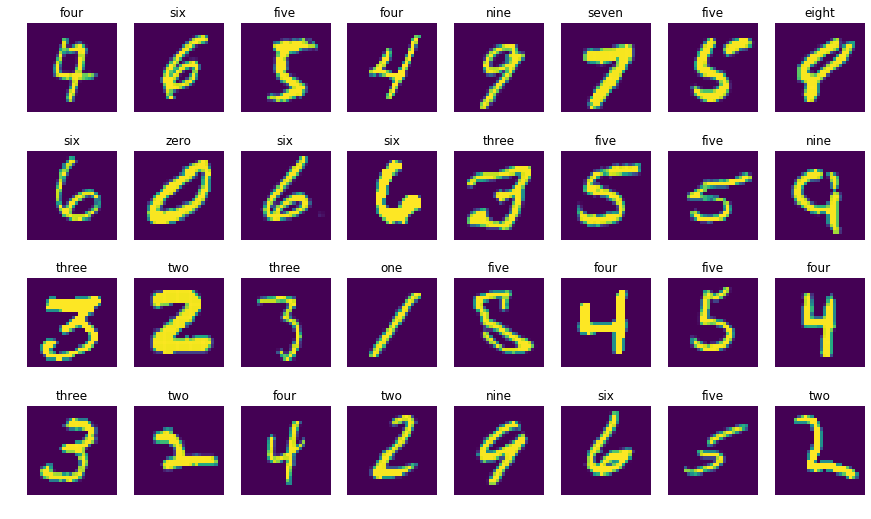

In [5]:
# show random images from train
cols = 8
rows = 4
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('False')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(mnist_digits[y_train[random_index]])
plt.show()

## Prepare data

We need to normalize inputs like this: $$x_{norm} = \frac{x}{255} - 0.5$$

We need to convert class labels to one-hot encoded vectors. Use __keras.utils.to_categorical__.

In [6]:
# normalize inputs
x_train2 = x_train/255-0.5 
x_test2 = x_test/255-0.5 

y_train2 = tf.keras.utils.to_categorical(y_train, num_classes=NUM_DIGITS) 
y_test2 = tf.keras.utils.to_categorical(y_test, num_classes=NUM_DIGITS) 

## Define CNN architecture

We need to add one channel to the train images in order to set them as viable inputs for the CNN.

We need to define a model which takes __(None, 28, 28, 1)__ input and predicts __(None, 10)__ output with probabilities for all digits. __None__ in shapes stands for batch dimension.

In [7]:
x_train2 = x_train2.reshape(len(x_train), 28,28,1)
x_test2 = x_test2.reshape(len(x_test),28,28,1)

In [8]:
def make_model():
    """
    Model architecture.
    """
    
    model = Sequential()
    model.add(Conv2D(32,kernel_size=(3, 3),padding='same',input_shape=(28, 28, 1),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64,kernel_size=(3, 3),padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64,kernel_size=(3, 3),padding='same',activation='relu'))
    model.add(Flatten())
    model.add(Dense(64,activation='relu'))
    model.add(Dense(NUM_DIGITS))  
    model.add(Activation("softmax"))
    
    return model

In [9]:
# describe model
K.clear_session()  # clear default graph
model = make_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                200768    
__________

## Train model

In [10]:
start = time.time()

INIT_LR = 5e-3  # initial learning rate
BATCH_SIZE = 1024
EPOCHS = 5

K.clear_session()  # clear default graph
# don't call K.set_learning_phase() !!! (otherwise will enable dropout in train/test simultaneously)
model = make_model()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer=keras.optimizers.adamax(lr=INIT_LR),  # for SGD
    metrics=['accuracy']  # report accuracy during training
)

# scheduler of learning rate (decay with epochs)
def lr_scheduler(epoch):
    return INIT_LR * 0.9 ** epoch

# callback for printing of actual learning rate used by optimizer
class LrHistory(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs={}):
        print("Learning rate:", K.get_value(model.optimizer.lr))

# fit model
model.fit(
    x_train2, y_train2,  # prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler), LrHistory()],
    validation_data=(x_test2, y_test2),
    shuffle=True,
    verbose=1
)

end = time.time()
print("")
print("Training time = %d seconds" %(end - start))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
Learning rate: 0.005
60000/60000 [==============================] - 46s 767us/step - loss: 0.5359 - acc: 0.8342 - val_loss: 0.1251 - val_acc: 0.9646
Epoch 2/5
Learning rate: 0.0045
60000/60000 [==============================] - 44s 732us/step - loss: 0.1018 - acc: 0.9694 - val_loss: 0.0718 - val_acc: 0.9785
Epoch 3/5
Learning rate: 0.00405
60000/60000 [==============================] - 44s 725us/step - loss: 0.0665 - acc: 0.9800 - val_loss: 0.0482 - val_acc: 0.9848
Epoch 4/5
Learning rate: 0.003645
60000/60000 [==============================] - 43s 719us/step - loss: 0.0532 - acc: 0.9840 - val_loss: 0.0448 - val_acc: 0.9857
Epoch 5/5
Learning rate: 0.0032805
60000/60000 [==============================] - 43s 722us/step - loss: 0.0455 - acc: 0.9862 - val_loss: 0.0369 - val_acc: 0.9874

Training time = 220 seconds


In [11]:
# save weights to file
model.save_weights("mnist_weights.h5")

In [12]:
# load weights from file (can call without model.fit)
model.load_weights("mnist_weights.h5")

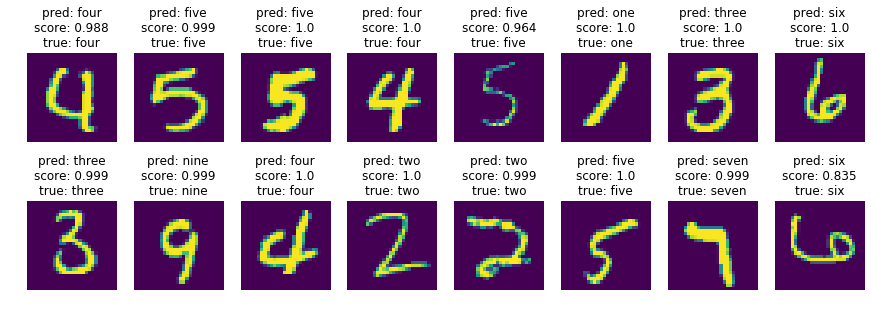

In [13]:
# make test predictions
y_pred_test = model.predict_proba(x_test2)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)

# inspect preditions
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_test[random_index, :])
        pred_label = mnist_digits[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = mnist_digits[y_test[random_index]]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()

## Create an estimator form the compiled Keras model

We convert the model created above to run on a multi-GPU environment using the TensorFlow Estimator API.
Estimators build the graph, so there is no explicit session here.

We build esimators using the tf.keras.estimator.model_to_estimator method.

Currently, tf.contrib.distribute.MirroredStrategy is the only supported distribution strategy. MirroredStrategy does in-graph replication with synchronous training using all-reduce on a single machine. 

To use DistributionStrategy with Keras, convert the tf.keras.Model to a tf.estimator.Estimator with tf.keras.estimator.model_to_estimator, then train the estimator.

When creating MirroredStrategy, you can specify a list of devices or set the num_gpus argument. The default uses all available GPUs.

In [14]:
def make_model():
    """
    Model architecture.
    """
    
    model = tf.keras.Sequential([
        L.Conv2D(32,kernel_size=(3, 3),padding='same',input_shape=(28, 28, 1),activation='relu'),
        L.MaxPooling2D(pool_size=(2, 2), strides=2),
        L.Conv2D(64,kernel_size=(3, 3),padding='same',activation='relu'),
        L.MaxPooling2D(pool_size=(2, 2), strides=2),
        L.Conv2D(64,kernel_size=(3, 3),padding='same',activation='relu'),
        L.Flatten(),
        L.Dense(64,activation='relu'),
        L.Dense(NUM_DIGITS, activation="softmax")  
    ])
     
    return model

Another way to construct a Keras model:

inputs = tf.keras.Input(shape=(28,28,1))  # Returns a placeholder 

x = tf.keras.layers.Conv2D(filters=32,  
                           kernel_size=(3, 3), 
                           activation=tf.nn.relu)(inputs) 
                           
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2)(x) 

x = tf.keras.layers.Conv2D(filters=64, 
                           kernel_size=(3, 3), 
                           activation=tf.nn.relu)(x) 
                           
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2)(x) 

x = tf.keras.layers.Conv2D(filters=64, 
                           kernel_size=(3, 3), 
                           activation=tf.nn.relu)(x) 
                           
x = tf.keras.layers.Flatten()(x) 

x = tf.keras.layers.Dense(64, activation=tf.nn.relu)(x) 

predictions = tf.keras.layers.Dense(NUM_DIGITS, activation=tf.nn.softmax)(x) 

model = tf.keras.Model(inputs=inputs, outputs=predictions)

In [15]:
K.clear_session()  # clear default graph
model = make_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                200768    
__________

In [21]:
INIT_LR = 5e-3  # initial learning rate
BATCH_SIZE = 1024
EPOCHS = 5

model.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer=tf.train.AdamOptimizer(learning_rate=INIT_LR),  
    metrics=['accuracy']  # report accuracy during training
)

NUM_GPUS = 2
strategy = tf.contrib.distribute.MirroredStrategy(num_gpus=NUM_GPUS)
#strategy = tf.contrib.distribute.MirroredStrategy()
config = tf.estimator.RunConfig(train_distribute=strategy)
estimator = tf.keras.estimator.model_to_estimator(model, config=config, model_dir='/tmp/model_dir4')

INFO:tensorflow:Initializing RunConfig with distribution strategies.
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Using the Keras model provided.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/model_dir4', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': <tensorflow.contrib.distribute.python.mirrored_strategy.MirroredStrategy object at 0x2b3d7276bba8>, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x2b3d7276b390>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_m

We need to define an input pipeline. The input_fn returns a tf.data.Dataset object used to distribute the data across multiple devices—with each device processing a slice of the input batch.

In [22]:
# ETL process

def input_fn(images, labels, epochs, batch_size):
    # Convert the inputs to a Dataset. (E)
    ds = tf.data.Dataset.from_tensor_slices((images, labels))
    # Shuffle, repeat, and batch the examples. (T)
    SHUFFLE_SIZE = 5000
    ds = ds.shuffle(SHUFFLE_SIZE).repeat(epochs).batch(batch_size)
    ds = ds.prefetch(buffer_size=2)
    # Return the dataset. (L)
    return ds

### Train the Estimator

In [23]:
class TimeHistory(tf.train.SessionRunHook):
    def begin(self):
        self.times = []
    def before_run(self, run_context):
        self.iter_time_start = time.time()
    def after_run(self, run_context, run_values):
        self.times.append(time.time() - self.iter_time_start)

In [24]:
start = time.time()

time_hist = TimeHistory()
BATCH_SIZE = 2000
EPOCHS = 5
estimator.train(lambda:input_fn(x_train2,
                                y_train2,
                                epochs=EPOCHS,
                                batch_size=BATCH_SIZE),
                                hooks=[time_hist])

end = time.time()
print("")
print("Training time = %d seconds" %(end - start))

INFO:tensorflow:Device is available but not used by distribute strategy: /device:CPU:0
INFO:tensorflow:Device is available but not used by distribute strategy: /device:XLA_GPU:0
INFO:tensorflow:Device is available but not used by distribute strategy: /device:XLA_CPU:0
INFO:tensorflow:Configured nccl all-reduce.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:batch_all_reduce invoked for batches size = 10 with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='/tmp/model_dir4/keras/keras_model.ckpt', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('/tmp/model_dir4/keras/keras_model.ckpt',)
INFO:tensorflow:Warm-starting variable: conv2d/kernel; prev_var_name: Uncha

### Performance

In [27]:
total_time = sum(time_hist.times)
print(f"total time with {NUM_GPUS} GPU(s): {total_time} seconds")
avg_time_per_batch = np.mean(time_hist.times)
print(f"""{BATCH_SIZE*NUM_GPUS/avg_time_per_batch} images/second with
        {NUM_GPUS} GPU(s)""")

total time with 2 GPU(s): 8.877770185470581 seconds
33792.26919964453 images/second with
        2 GPU(s)


### Evaluate the Estimator

In [28]:
estimator.evaluate(lambda:input_fn(x_test2, 
                                   y_test2,
                                   epochs=1,
                                   batch_size=BATCH_SIZE))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-01-30-08:59:18
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/model_dir4/model.ckpt-75
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-01-30-08:59:19
INFO:tensorflow:Saving dict for global step 75: accuracy = 0.9848, global_step = 75, loss = 0.045820463
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 75: /tmp/model_dir4/model.ckpt-75


{'accuracy': 0.9848, 'loss': 0.045820463, 'global_step': 75}